<a href="https://colab.research.google.com/github/rubyvanrooyen/NIFTyworkshop/blob/master/NIFTy_RMsynth_CorrelatedFieldModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

Copyright(C) 2013-2020 Max-Planck-Society    
Copyright(C) 2019, National Research Foundation
(South African Radio Astronomy Observatory)

NIFTy is being developed at the Max-Planck-Institut fuer Astrophysik.

In [ ]:
!git clone -b NIFTy_7 --single-branch https://gitlab.mpcdf.mpg.de/ift/nifty.git
!pip install ./nifty

In [ ]:
!git clone https://github.com/rubyvanrooyen/NIFTyworkshop.git
!ln -s NIFTyworkshop/faraday_response.py

In [ ]:
import nifty7 as ift
import numpy
import numpy as np
from matplotlib import pylab

# Philipp's NFFT operator to calculate RMTF
import faraday_response

In [ ]:
def faraday_synthesis(x, pol, phi_range):
    f = numpy.zeros(len(phi_range), dtype=complex)

    N = len(x)
    xmean = x.mean()

    for k, phi in enumerate(phi_range):
        f[k] = numpy.sum(pol * numpy.exp(-2j * phi * x ))/N
                    
    return f

In [ ]:
import io
import requests
# example input signal (1D with power spectrum)
url='https://raw.githubusercontent.com/rubyvanrooyen/NIFTyworkshop/master/PDATA-RMSYN-1.TXT'
res = requests.get(url)
f = io.StringIO(res.text)
data = f.readlines()

# four columns in each file: frequencies in  Hz, Stokes Q , Stokes U and Stokes I in Jansky per beam
freq_hz = []
stokes_q = []
stokes_u = []
stokes_i = []
for line in data:
    [freq, q, u, i] = line.strip().split()
    freq_hz.append(freq)
    stokes_q.append(q)
    stokes_u.append(u)
    stokes_i.append(i)
freq_hz = np.array(freq_hz, dtype=float)
stokes_q = np.array(stokes_q, dtype=float)
stokes_u = np.array(stokes_u, dtype=float)
stokes_i = np.array(stokes_i, dtype=float)

# fractional polarisation
# P = pI = Q + iU
Pcorr = stokes_q + 1j*stokes_u
p = Pcorr/stokes_i

# c = Speed of Light (299,792,458 m/s)
# define lambda^2
lamsq = (3.0e8/freq_hz)**2  # m^2

In [ ]:
phi_max = 10000
phi_min = -phi_max
d_phi = (phi_max - phi_min)/float(len(p))
phi_range = numpy.arange(phi_min, phi_max, d_phi)

# dirty spectrum calculation
f = faraday_synthesis(lamsq, p, phi_range)

In [ ]:
# plot data (p)
fig, (ax0, ax1) = pylab.subplots(nrows=1, ncols=2, figsize=(15, 7), facecolor='white')
ax0.plot(lamsq, numpy.absolute(p), 'g-', label='amp', lw=1)
ax0.plot(lamsq, numpy.real(p), 'r-', label='real', lw=1, alpha=0.3)
ax0.plot(lamsq, numpy.imag(p), 'b-.', label='imag', lw=1, alpha=0.3)
ax0.set_xlabel(r'Wavelength [m$^2$]')
ax0.set_ylabel(r'Fractional polarisation')
ax0.legend(loc=0)

ax1.plot(phi_range, numpy.absolute(f), 'g-', label='amp', lw=1)
ax1.plot(phi_range, numpy.real(f), 'r-', label='real', lw=1, alpha=0.3)
ax1.plot(phi_range, numpy.imag(f), 'b-.', label='imag', lw=1, alpha=0.3)
ax1.set_xlabel(r'Faraday depth [rad/m$^2$]')
ax1.set_ylabel(r'Faraday spectrum')
ax1.legend(loc=0)

pylab.savefig('data_and_dirty_spectrum.png')

pylab.show()

In [ ]:
from scipy.signal import savgol_filter as savitzky_golay
smoothed_curve = savitzky_golay(numpy.absolute(p), 21, 3)
detrended_amp = numpy.absolute(p) - smoothed_curve

fig, axs = pylab.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor='white')
axs[0].plot(lamsq, numpy.absolute(p),
            'k-', lw=1, label='amp')
axs[0].plot(lamsq, smoothed_curve,
            'y-', lw=1, label='smoothed amp')
axs[0].set_xlabel(r'Wavelength [m$^2$]')
axs[0].set_ylabel(r'Fractional polarisation')
axs[0].legend(loc=0)

axs[1].plot(lamsq, detrended_amp,
            'b-', lw=1, label='detrended amp')
axs[1].axhline(y=np.mean(detrended_amp),
               color='k', linestyle=':', alpha=0.7, label='mean')
region_size = 450  # samples
axs[1].axvspan(lamsq[-1], lamsq[-region_size],
               alpha=0.1, color='red', label='var cal region')
axs[1].axhline(y=np.std(detrended_amp[-region_size:]),
               color='k', linestyle='--', alpha=0.7, label='region std dev')
axs[1].set_xlabel(r'Wavelength [m$^2$]')
axs[1].set_ylabel(r'Fractional polarisation')
axs[1].legend(loc=0)

# noise estimate from selected regions and approximated as
# noise variance = sqrt(var(abs(data)))
# var(amp) = std(amp)**2 --> var(p) = std(amp)
noisevar = 0.5*np.std(detrended_amp[-region_size:])
print(f'Assumed Gaussian noise variance {noisevar:.5f}')

pylab.savefig('noise_estimation.png')

pylab.show()

In [ ]:
# d = q+1j*u
print(f'Length of input signal (p) = {len(p)} samples')
n_pixels = 2048

# s = Faraday spectrum
distance = 2.*phi_max/n_pixels
s_space = ift.RGSpace(n_pixels, distance)

# R = Maps a Faraday spectrum to the respective data
# R: domain(s) -> domain(d)
R = faraday_response.NFFT(s_space, lamsq)
# linear operator maps

# The next line checks < y , R (x) > = < R.adjoint(y), x > for random x, y
ift.extra.check_linear_operator(R, np.complex128, np.complex128)

d_space = R.target

In [ ]:
# Define test signal as field
data = ift.makeField(d_space, p)

# N the covariance matrix
N = ift.ScalingOperator(d_space, noisevar)

In [ ]:
args = {
    'offset_mean': 0,
    'offset_std': (1e-3, 1e-6),  # (mean, std)

    # Amplitude of field fluctuations (mean, std)
    'fluctuations': (2., 1.), 

    # Exponent of power law power spectrum component (mean, std)
    'loglogavgslope': (-2, 0.5),  #(-4., 1),

    # Amplitude of integrated Wiener process power spectrum component (mean, std)
#    'flexibility': (5, 2.),
    'flexibility': (2.2, 1.0),

    # How ragged the integrated Wiener process component is (mean, std)
    'asperity': (0.5, 0.5)
}

# set up the likelihood domain and target
re = ift.SimpleCorrelatedField(s_space, **args, prefix='real')
im = ift.SimpleCorrelatedField(s_space, **args, prefix='imag')

In [ ]:
re_pspec = re.power_spectrum
im_pspec = im.power_spectrum
signal = re.real + 1j*im.real

# plot the power spectrum options
plot = ift.Plot()
plot.add([re_pspec(ift.from_random(re_pspec.domain)) for _ in range(5)], title='Re Power Spectrum')
plot.add([im_pspec(ift.from_random(im_pspec.domain)) for _ in range(5)], title='Im Power Spectrum')
plot.output(ny=1, nx=2, xsize=15, ysize=7)

In [ ]:
# R(signal) = R @ (re.real + 1j*im.real)
likelihood = ift.GaussianEnergy(mean=data, inverse_covariance=N.inverse) @ R @ (re.real + 1j*im.real)

In [ ]:
# define hamiltonian
ic_sampling = ift.AbsDeltaEnergyController(name='Sampling', deltaE=0.05, iteration_limit=100)
H = ift.StandardHamiltonian(likelihood, ic_sampling)

In [ ]:
# initialise the minimization
initial_mean = ift.MultiField.full(H.domain, 0.)
mean = initial_mean
ic_newton = ift.AbsDeltaEnergyController(name='Newton', deltaE=0.5, iteration_limit=35)
minimizer = ift.NewtonCG(ic_newton)

In [ ]:
# number of samples used to estimate the KL
N_samples = 20

# Draw new samples to approximate the KL five times
#for i in range(5):
for i in range(1):
    # Draw new samples and minimize KL
    KL = ift.MetricGaussianKL.make(mean, H, N_samples)
    KL, convergence = minimizer(KL)
    mean = KL.position

In [ ]:
# operator to calculate running mean
sc = ift.StatCalculator()
# draw posterior samples
for sample in KL.samples:
    sc.add(signal(sample + KL.position))

In [ ]:
# plot the posterior mean (sc.mean)
# and look at the standard deviation (sc.var)
plot = ift.Plot()
plot.add(np.abs(sc.mean), title="Posterior Mean")
plot.add(ift.sqrt(np.abs(sc.var)), title="Posterior Standard Deviation")
plot.output(ny=1, nx=2, xsize=15, ysize=7)

0.02282996821064603 0.0031771759005629185 0.028183221518143196


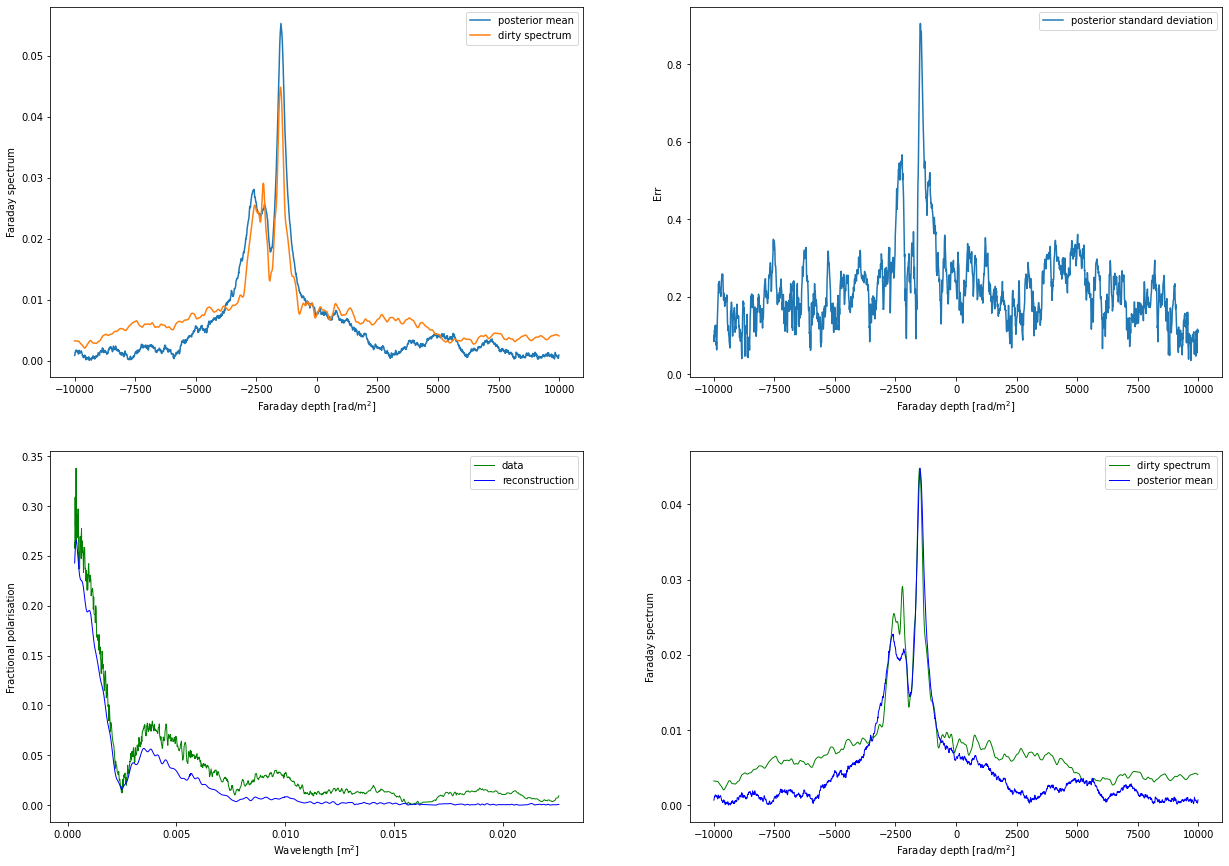

In [17]:
high_res_phi_range = np.arange(phi_min, phi_max, distance)
KL_model_Faraday_spectrum = numpy.absolute(sc.mean.val)
amp_scale = numpy.absolute(f).max()/KL_model_Faraday_spectrum.max()
scale = 0.5*np.sqrt(noisevar)
print(amp_scale, noisevar, scale)

# plot the posterior mean (sc.mean)
# and look at the standard deviation (sc.var)
fig, axs = pylab.subplots(nrows=2, ncols=2, figsize=(21, 15), facecolor='white')
# plot the posterior mean (sc.mean)
# and look at the standard deviation (sc.var)
axs[0,0].plot(high_res_phi_range, scale*np.abs(sc.mean.val), label="posterior mean")
axs[0,0].plot(high_res_phi_range, np.abs(R.adjoint(data).val), label="dirty spectrum")
axs[0,0].set_xlabel(r'Faraday depth [rad/m$^2$]')
axs[0,0].set_ylabel(r'Faraday spectrum')
axs[0,0].legend(loc=0)

axs[0,1].plot(high_res_phi_range, ift.sqrt(np.abs(sc.var)).val, label="posterior standard deviation")
axs[0,1].legend(loc=0)
axs[0,1].set_xlabel(r'Faraday depth [rad/m$^2$]')
axs[0,1].set_ylabel(r'Err')
axs[0,1].legend(loc=0)

axs[1,0].plot(lamsq, numpy.absolute(p), 'g-', label='data', lw=1)
axs[1,0].plot(lamsq, np.abs(R(sc.mean).val), 'b-', label='reconstruction', lw=1)
axs[1,0].set_xlabel(r'Wavelength [m$^2$]')
axs[1,0].set_ylabel(r'Fractional polarisation')
axs[1,0].legend(loc=0)

axs[1,1].plot(phi_range, numpy.absolute(f), 'g-',
            label='dirty spectrum',
            lw=1)
axs[1,1].plot(high_res_phi_range, KL_model_Faraday_spectrum*amp_scale, 'b-',
            label="posterior mean",
            lw=1)
axs[1,1].set_xlabel(r'Faraday depth [rad/m$^2$]')
axs[1,1].set_ylabel(r'Faraday spectrum')
axs[1,1].legend(loc=0)

pylab.savefig('rm_synth.png')

pylab.show()